In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_predict
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, permutation_test_score

In [2]:
# taken from https://gist.github.com/smazzanti
# with explanations from:
# https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb

import numpy as np


def regression_roc_auc_score(y_true, y_pred, num_rounds=10000):
    """
    Computes Regression-ROC-AUC-score.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,).
            Binary or continuous target variable.
    y_pred: array-like of shape (n_samples,). Target scores.
    num_rounds: int or string.
                If integer, number of random pairs of observations.
                If string, 'exact', all possible pairs will be evaluated.

    Returns:
    -------
    rroc: float. Regression-ROC-AUC-score.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_pairs = 0
    num_same_sign = 0

    for i, j in _yield_pairs(y_true, num_rounds):
        diff_true = y_true[i] - y_true[j]
        diff_score = y_pred[i] - y_pred[j]
        if diff_true * diff_score > 0:
            num_same_sign += 1
        elif diff_score == 0:
            num_same_sign += .5
        num_pairs += 1

    return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
    """
    Returns pairs of valid indices.

    Indices must belong to observations having different values.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,).
            Binary or continuous target variable.
    num_rounds: int or string.
            If integer, number of random pairs of observations to return.
            If string, 'exact', all possible pairs will be returned.

    Yields:
    -------
    i, j: tuple of int of shape (2,). Indices referred to a pair of samples.

    """
    import numpy as np

    if num_rounds == 'exact':
        for i in range(len(y_true)):
            for j in np.where(
                    (y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
                yield i, j
    else:
        for r in range(num_rounds):
            i = np.random.choice(range(len(y_true)))
            j = np.random.choice(np.where(y_true != y_true[i])[0])
            yield i, j

In [3]:
save_dir = '/home/jl274628/Documents/PLOT_RAPPORT/SVR/'

In [6]:
scaler = StandardScaler()

X = pd.read_csv('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/full_embeddings.csv')
cols = [f'dim{k}' for k in range(1,11)]
subjects_155 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/subjects.csv')
X = pd.merge(subjects_155, X)
X = X[cols].to_numpy()
X = scaler.fit_transform(X)

Y = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/morpho_labels.csv')
subjects_155.columns=['subject']
Y = pd.merge(Y, subjects_155)

In [7]:
nb_runs = 5
nb_iter = 10000
num_rounds = 10000
dict_aucs = {}

for label in Y.columns[1:]:

    Y_ = Y[label].to_numpy()
    Y_ = Y_.reshape(-1, 1)
    Y_ = scaler.fit_transform(Y_)

    score_list = []
    pvalue_list = []
    labels_pred_sum = np.zeros((len(Y_)))
    for i in range(nb_runs):
        model = LinearSVR(C=0.1, max_iter=nb_iter, random_state=i)
        labels_pred = cross_val_predict(model, X, Y_[:,0], cv=5)
        labels_pred_sum += np.array(labels_pred)
        score = regression_roc_auc_score(Y_, labels_pred, num_rounds)
        score_list.append(score)
        _ , _, pvalue = permutation_test_score(
    model, X, Y_[:, 0], scoring="r2", cv=5, n_permutations=200, random_state=i
)
        pvalue_list.append(pvalue)
    pvalue = np.mean(pvalue)
    labels_pred = labels_pred_sum / nb_runs
    labels_pred = labels_pred.reshape(-1, 1)
    labs = np.hstack((Y_, labels_pred))
    labs = pd.DataFrame(labs)
    labs.columns=['truth', 'pred']
    dict_aucs[label]=(np.mean(score_list), np.std(score_list), labs, pvalue)
    #break

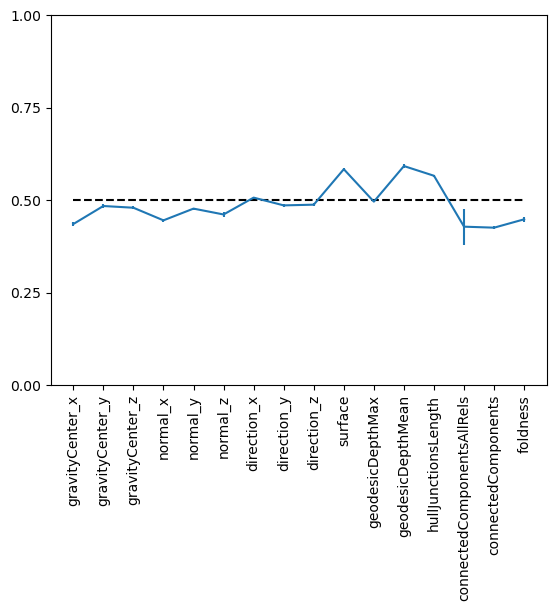

In [ ]:

##### ADD PVALUE

x = dict_aucs.keys()
y = [dict_aucs[label][0] for label in x]
error = [dict_aucs[label][1] for label in x]

fig, ax = plt.subplots()

ax.errorbar(x, y, error)
ax.set_ylim(0, 1)
plt.xticks(rotation=90)
ax.set_yticks([0., 0.25, 0.5, 0.75, 1])
ax.plot(0.5*np.ones(len(y)), c='black', linestyle='--')
plt.show()

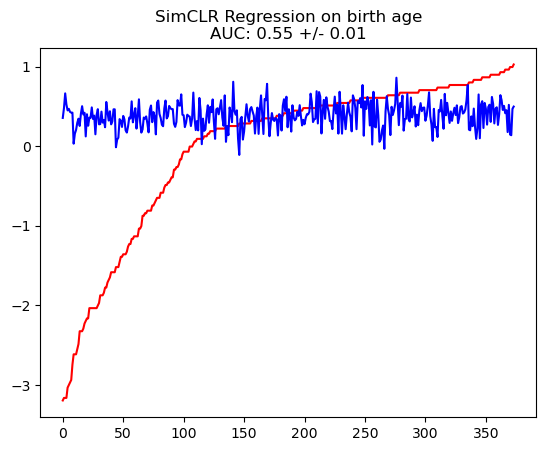

In [ ]:
# same on birth_age

nb_runs = 5
nb_iter = 10000
num_rounds = 10000

X = pd.read_csv('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/full_embeddings.csv')
cols = [f'dim{k}' for k in range(1,11)]
subjects_155 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/subjects.csv')
#X = pd.merge(subjects_155, X)
X = X[cols].to_numpy()
X = scaler.fit_transform(X)

labels_age = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/preterm_labels.csv', usecols=['Subject', 'birth_age'])
labels_age.columns=['ID', 'birth_age']
#labels_age = pd.merge(subjects_155, labels_age)

Y_ = labels_age['birth_age'].to_numpy()
Y_ = Y_.reshape(-1, 1)
Y_ = scaler.fit_transform(Y_)

score_list = []
pvalue_list = []
labels_pred_sum = np.zeros((len(Y_)))
for i in range(nb_runs):
    model = LinearSVR(C=0.1, max_iter=nb_iter, random_state=i)
    labels_pred = cross_val_predict(model, X, Y_[:,0], cv=5)
    labels_pred_sum += np.array(labels_pred)
    score = regression_roc_auc_score(Y_, labels_pred, num_rounds)
    score_list.append(score)
    score, perm_scores, pvalue = permutation_test_score(
    model, X, Y_[:, 0], scoring="r2", cv=5, n_permutations=200, random_state=i
)
    pvalue_list.append(pvalue)
pvalue=np.mean(pvalue_list)
labels_pred = labels_pred_sum / nb_runs
labels_pred = labels_pred.reshape(-1, 1)
labs = np.hstack((Y_, labels_pred))
labs = pd.DataFrame(labs)
labs.columns=['truth', 'pred']
labs = labs.sort_values(by='truth')
truth, pred = labs['truth'].tolist(),labs['pred'].tolist()
plt.plot(truth, color='r')
plt.plot(pred, color='b')
plt.title(f'SimCLR Regression on birth age\nAUC: {np.mean(score_list):.2f} +/- {2*np.std(score_list):.2f}')
#plt.xlabel('birth_age')
plt.savefig(save_dir+'birth_age_regression_374.jpg')
plt.show()

dict_aucs['birth_age'] = (np.mean(score_list), np.std(score_list), labs, pvalue)

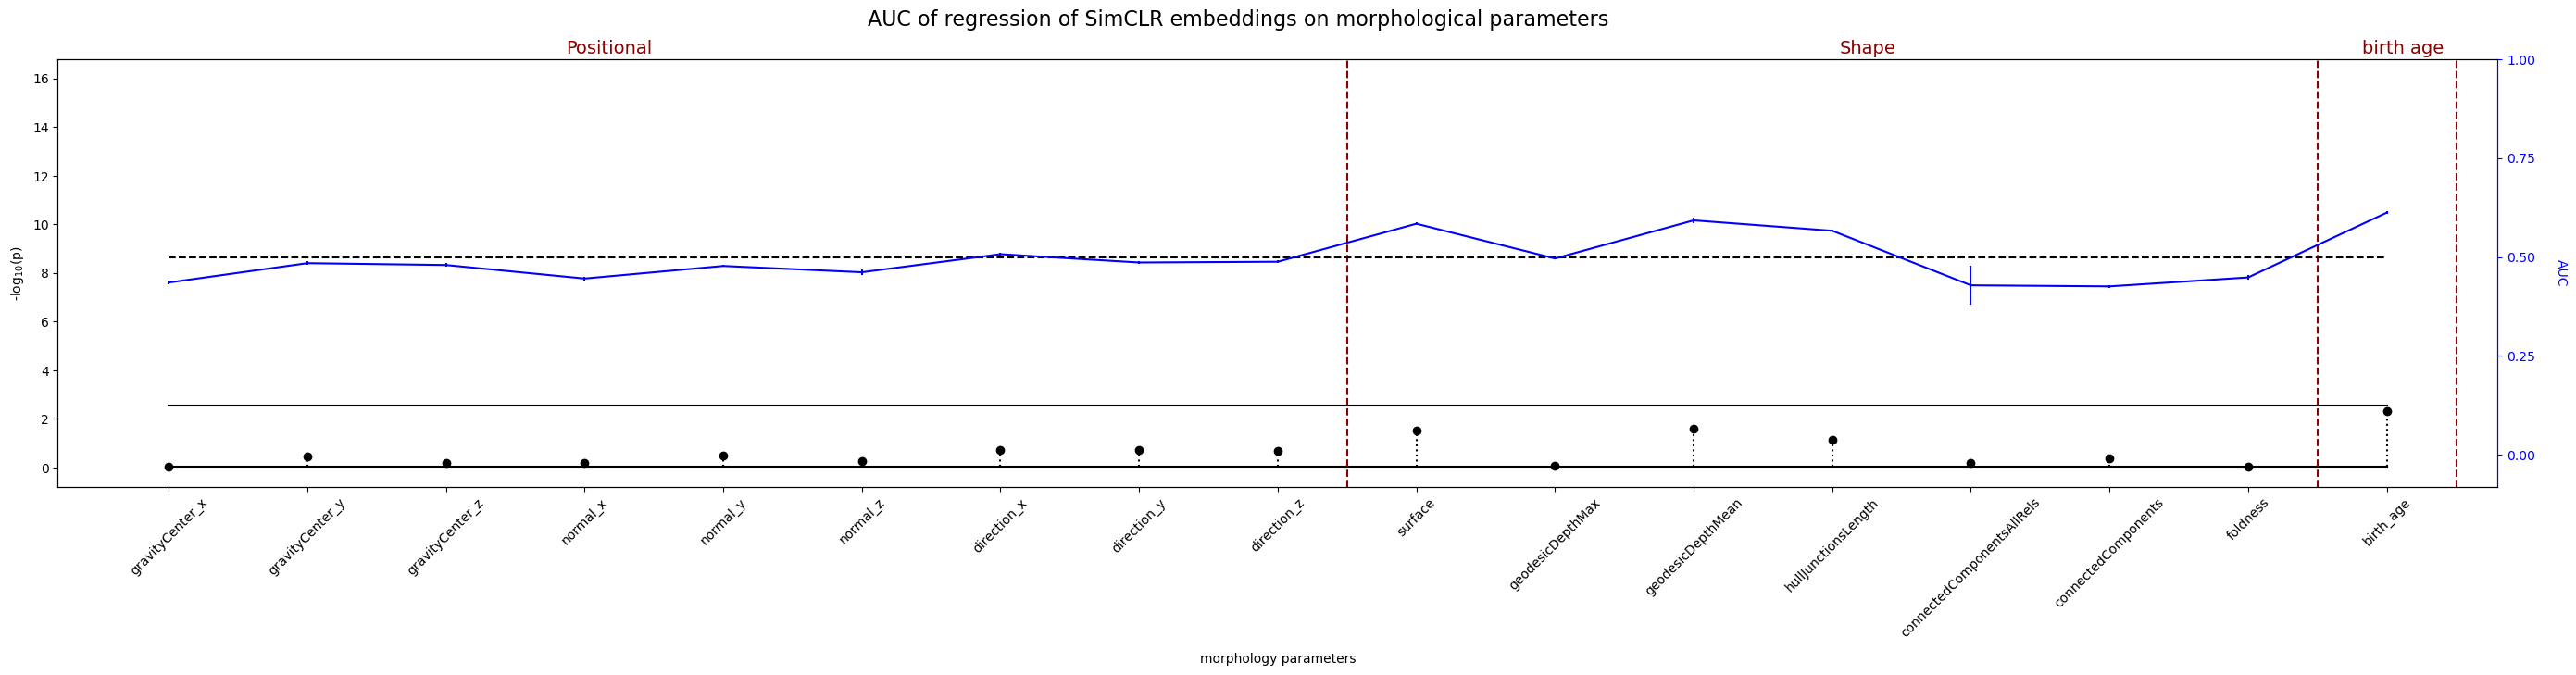

In [335]:
nb_components = len(dict_aucs.keys())
fig, ax = plt.subplots(figsize=(2*nb_components, 6))

fontsize=22
labelsize=20
plt.xticks(rotation=30)
ax.xaxis.set_tick_params(labelsize = labelsize)
ax.yaxis.set_tick_params(labelsize = labelsize)

pvalues = [val[3] for _, val in dict_aucs.items()]
markerline, stemlines, baseline = \
        ax.stem(dict_aucs.keys(),
              -np.log10(pvalues),
              bottom=-np.log10(np.max(pvalues)),
              basefmt= 'C0',
              linefmt=':')
plt.setp(markerline, 'color', 'black')
plt.setp(stemlines, 'color', 'black')
plt.setp(baseline, 'color', 'black')
ax.plot(-np.log10(0.05/(nb_components))*np.ones(nb_components), c='black')
ax.set_ylabel("-log$_{10}$(p)", labelpad=5.0)
to_keep_1 = ax.set_xlabel("morphology parameters", labelpad=10.0)

ax.axline((8.5, 0), (8.5, 16), color='darkred', linestyle='--')
ax.axline((15.5, 0), (15.5, 16), color='darkred', linestyle='--')
ax.axline((16.5, 0), (16.5, 16), color='darkred', linestyle='--')

ax2 = ax.twinx()
ax2.xaxis.set_tick_params(labelsize = labelsize)
ax2.yaxis.set_tick_params(labelsize = labelsize)
y = [dict_aucs[label][0] for label in dict_aucs.keys()]
error = [dict_aucs[label][1] for label in dict_aucs.keys()]
ax2.errorbar(dict_aucs.keys(), y, error, c='blue')
ax2.set_ylim([0., 1])
ax2.set_ylabel('AUC', color='b', rotation=270, labelpad=25)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.spines['right'].set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(-0.08)
ax2.plot(0.5*np.ones((nb_components)), color='black', linestyle='--')

to_keep_2 = plt.text(x=0.5, y=0.94, s=f"AUC of regression of SimCLR embeddings on morphological parameters", fontsize=fontsize+2, ha="center", transform=fig.transFigure)
plt.text(x=0.3, y=0.89, s="Positional", fontsize=fontsize+2, ha="center", transform=fig.transFigure, color='darkred')
plt.text(x=0.7, y=0.89, s="Shape", fontsize=fontsize+2, ha="center", transform=fig.transFigure, color='darkred')
plt.text(x=0.87, y=0.89, s="birth age", fontsize=fontsize, ha="center", transform=fig.transFigure, color='darkred')
plt.savefig(save_dir+'SVR_morpho.jpg', facecolor='white', bbox_extra_artists=(to_keep_1, to_keep_2), bbox_inches='tight')
plt.show()

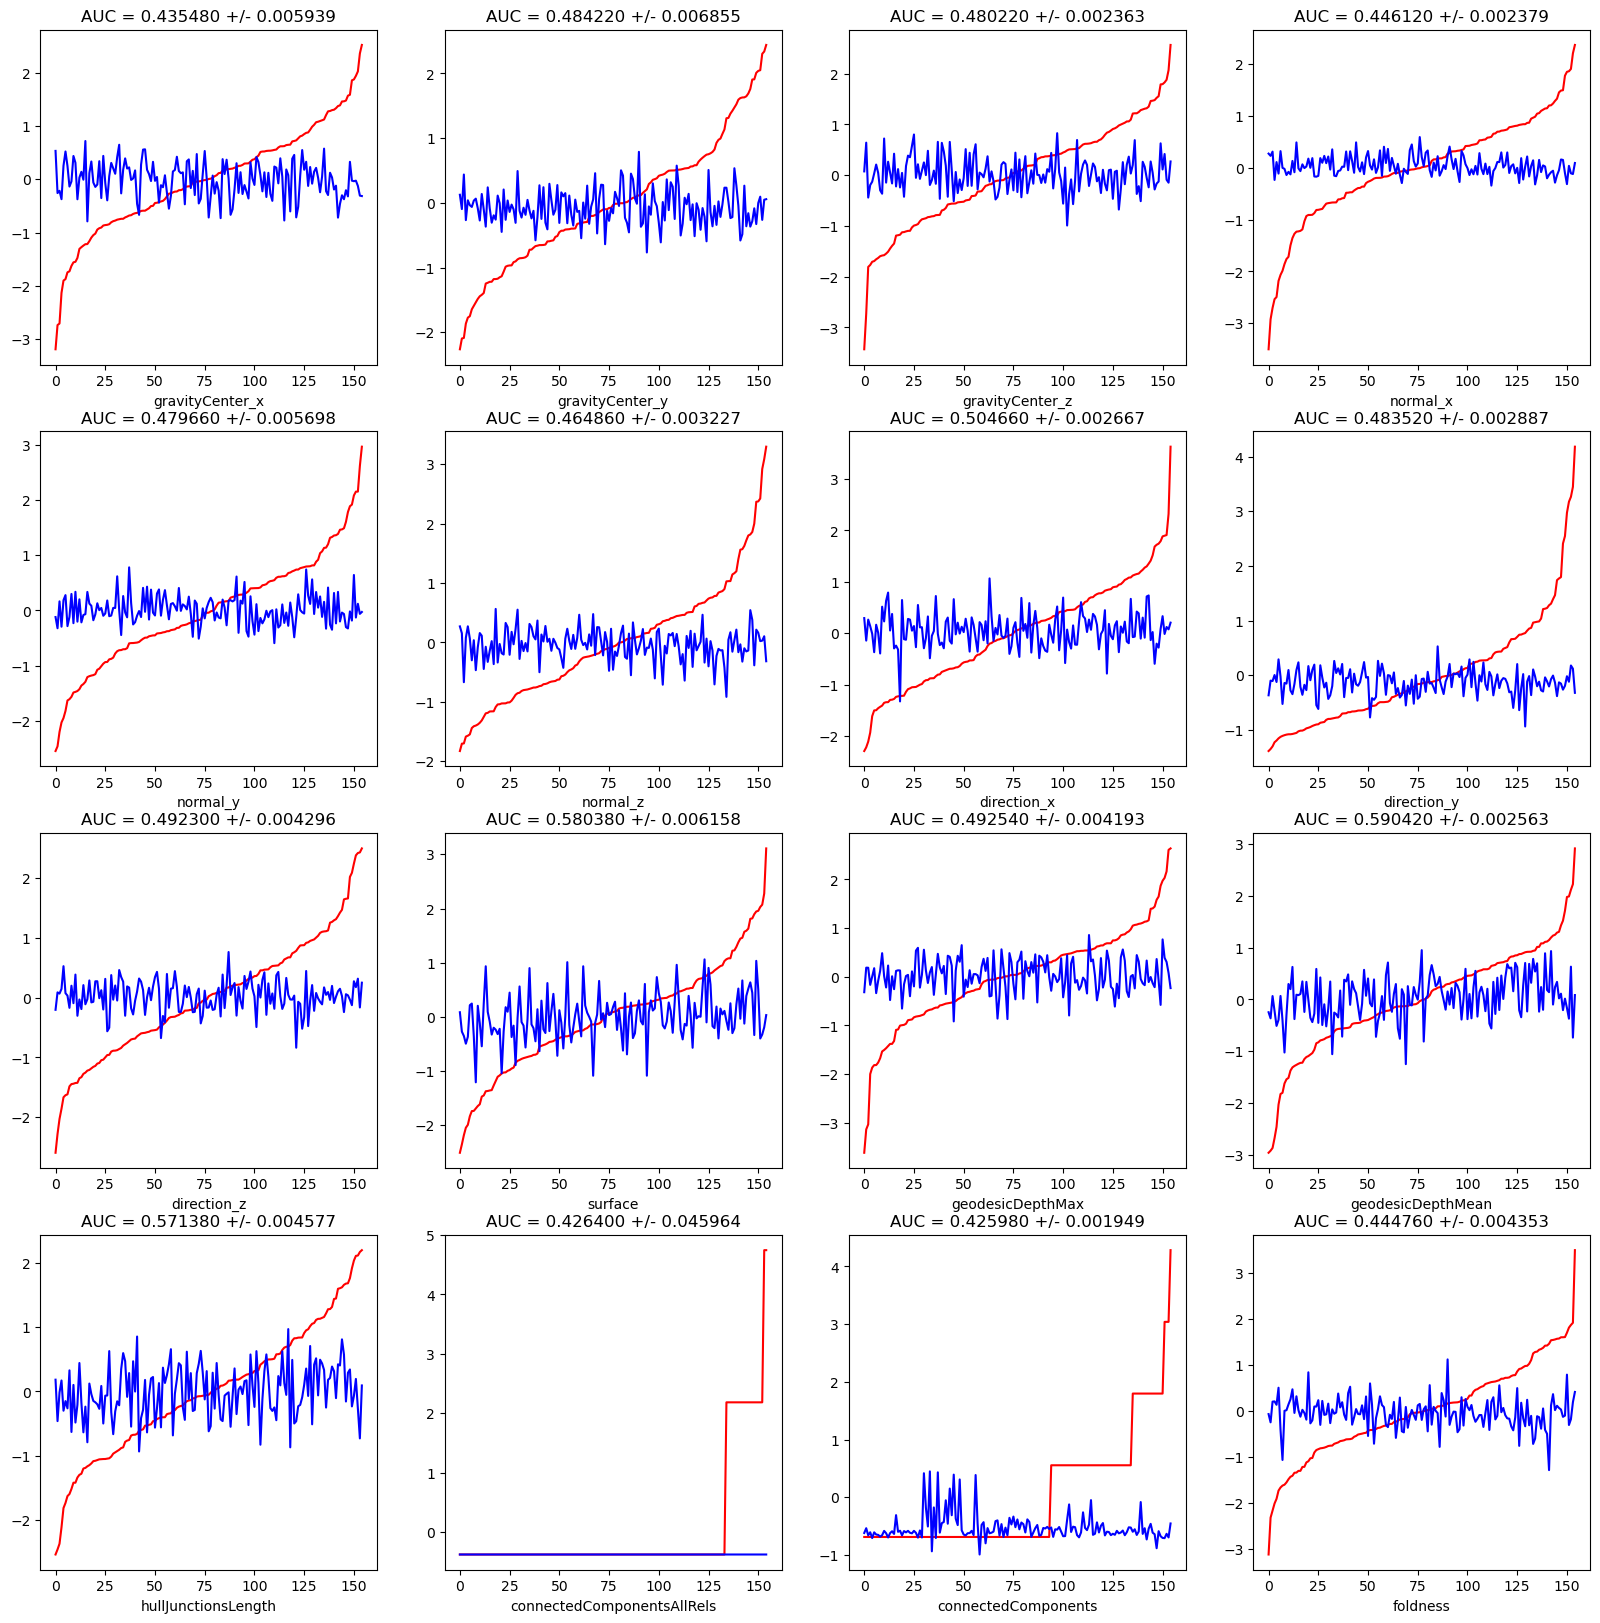

In [282]:
fig, axs = plt.subplots(figsize=(20,20), nrows=4, ncols=4)
for idx, label in enumerate(dict_aucs.keys()):
    ax = axs[idx//4, idx%4]
    labs = dict_aucs[label][2]
    labs = labs.sort_values(by='truth')
    truth, pred = labs['truth'].tolist(),labs['pred'].tolist()
    ax.plot(truth, color='r')
    ax.plot(pred, color='b')
    ax.set_xlabel(label)
    ax.set_title(f'AUC = {dict_aucs[label][0]:2f} +/- {dict_aucs[label][1]:2f}')
plt.show()

makes sense that the regression is not so good as SimCLR uses whole crop instead of just the sulcus.

don't try to make the real distribution linear with a transformation as we want to know the capacity of the model to linearly find the variables, as it would mean it can use them individually in the classification.

Using different classification thresholds is easier than regression as it allows for different fittings on different thresholds. So if the model captures features which are relevant for one class of age only, it will help for classification, but not necessarily as clearly for regression as only a single fit is done for the whole dataset. 0.6 is not so bad: reference point for the other variables ? Even though they seem to be easier to encode. No: not significant!

L2 norm is minimised, so the fitting on the whole dataset is almost constant based on 37+ weeks, whereas the AUC is bad because it doesn't force to fit the age properly ? With 155 subjects, the fitting takes into account all ages... In any case, only the middle part of the distribution seems to be quite properly fit.

Peut-être peut-on aider ces regressions à converger, en jouant sur la distribution des données ou sur la métrique d'évaluation.

CONCLUSION: L'âge est plus encodé que n'importe quelle variable morphométrique, du moins à l'échelle globale. On ne peut pas vraiment conclure sur l'impact de chaque variable sur la classification SimCLR, mais on peut voir l'importance relative de chaque variable morpho dans les embeddings SimCLR. Mais la régression sur l'âge n'est pas significative si on l'ajoute au groupe des corrrel testées... On peut conclure que le modèle n'apprend pas bêtement des paramètres morpho car aucune variable ne ressort significativement, mais est-ce la bonne méthode de pvalue si même le birth age ne l'est pas ? ON PEUT AUSSI CONCLURE QUE LES REGRESSIONS NE SONT JAMAIS SIGNIFICATIVES, DONC IL VAUT MIEUX TRAVAILLER EN CLASSIF ? NOTRE ESPOIR EST QUE LE MODÈLE APPRENNE DES PARAMÈTRES DE FORME. PAS DE RAISON QUE L'ÂGE SOIT CONTINU SELON DES PARAMS DE FORME ? ET POURTANT C'EST PRESQUE LA MÊME CHOSE QUE L'ON FAIT AVEC LA CLASSIF, SI CE N'EST QU'ON AUTORISE DES COMBINAISONS LINÉAIRES PAR MORCEAUX AVEC LES DIFFÉRENTS SEUILS, DONC SEULEMENT UN PEU PLUS DE FLEXIBILITÉ.

Commenter la présence potentielle de solutions triviales ? Qui empêchent la convergence, et donc rendent les choses non significatives, car la convergence sera la même qq soient les labels. Faire ce commentaire avec birth age ?